In [1]:
import sys
sys.path.append("../scripts")
sys.path.append("../datasets")


In [3]:
from cargar_dataset import cargar_dataset
from config_datasets import config_datasets
from evaluacion import evaluar_sampler_holdout
from custom_samplers import PCSMOTEWrapper

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (
    f1_score, balanced_accuracy_score,
    matthews_corrcoef, cohen_kappa_score
)
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder
from pc_smote import PCSMOTE
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import f1_score, balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from itertools import product
import numpy as np
import pandas as pd
from datetime import datetime  

In [ ]:

def evaluar_pcsmote_grid_search(nombre_dataset, config, percentiles_densidad, percentiles_riesgo, criterios_pureza, modelo_clasificador, nombre_modelo):
    print(f"📂 Cargando dataset: {nombre_dataset}")

    # 1) Cargar dataset según los parámetros recibidos (ruta, columnas, tipo, etc.)
    X, y, _ = cargar_dataset(
        path=config["path"],
        clase_minoria=config.get("clase_minoria"),
        col_features=config.get("col_features"),
        col_target=config.get("col_target"),
        sep=config.get("sep", ","),
        header=config.get("header", None),
        binarizar=False,
        tipo=config.get("tipo", "tabular")
    )

    # 2) Codificar etiquetas si son strings u objetos
    if y.dtype == object or isinstance(y[0], str):  
        y = LabelEncoder().fit_transform(y)

    # 3) Si es un dataset de imágenes, aplastar (reshape) cada imagen a vector 1D
    # Esto convierte (N, H, W, C) en (N, H*W*C) para trabajar como tabular
    if config.get("tipo") == "imagen":
        X = X.reshape((X.shape[0], -1)).astype(np.float32)

    # 4) Obtener clases minoritarias si están definidas
    clases_minor = config.get("clases_minor", [])
    resultados = []

    # 5) Dividir en train/test con estratificación, antes del sobremuestreo
    X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    # 6) Generar todas las combinaciones posibles entre los parámetros definidos
    combinaciones = list(product(percentiles_densidad, percentiles_riesgo, criterios_pureza))

    # 7) Iterar sobre cada combinación y aplicar sobremuestreo + entrenamiento + evaluación
    for idx, (pdens, priesgo, criterio) in enumerate(combinaciones, start=1):
        inicio = datetime.now()
        print(f"#{idx:02d} 🧪 {nombre_modelo} | {nombre_dataset} | Densidad: {pdens} | Riesgo: {priesgo} | Pureza: {criterio}")
        print(f"⏱️  Tiempo de inicio: {inicio.strftime('%H:%M:%S')} hs")        

        try:
            # 7.a) Inicializar sampler PCSMOTE con los parámetros actuales
            sampler = PCSMOTE(
                random_state=42,
                percentil_densidad=pdens,
                percentil_dist=priesgo,
                criterio_pureza=criterio,
                modo_espacial='3d'  # Puede usarse '2d' si se desea modificar
            )

            # 7.b) Aplicar sobremuestreo sobre el set de entrenamiento (solo si método está definido)
            if hasattr(sampler, "fit_resample_multiclass"):
                X_res, y_res = sampler.fit_resample_multiclass(X_train_eval, y_train_eval)
            else:
                X_res, y_res = sampler.fit_resample(X_train_eval, y_train_eval)

            # 7.c) Entrenar modelo sobre los datos aumentados
            modelo_clasificador.fit(X_res, y_res)

            # 7.d) Predecir sobre el set de evaluación (test)
            y_pred = modelo_clasificador.predict(X_test_eval)

            # 7.e) Calcular métricas de rendimiento
            f1_macro = f1_score(y_test_eval, y_pred, average='macro')
            balanced_acc = balanced_accuracy_score(y_test_eval, y_pred)
            mcc = matthews_corrcoef(y_test_eval, y_pred)
            kappa = cohen_kappa_score(y_test_eval, y_pred)

            # 7.f) Si hay clases minoritarias definidas, calcular también f1_score sobre ellas
            f1_minor = None
            if clases_minor:
                mask = np.isin(y_test_eval, clases_minor)
                if np.any(mask):
                    f1_minor = f1_score(y_test_eval[mask], y_pred[mask], average='macro')
                    print(f"📊 f1_minor sobre {np.sum(mask)} muestras minoritarias.")
                    print("✔️ Verdaderas:", y_test_eval[mask])
                    print("❌ Predichas:", y_pred[mask])

            # 7.g) Mostrar resumen de rendimiento
            print(f"✅ Config OK | F1_macro: {f1_macro:.4f}" + (f", F1_minor: {f1_minor:.4f}" if f1_minor else ""))

            # 7.h) Guardar resultados de esta corrida
            resultados.append({
                'dataset': nombre_dataset,
                'modelo': nombre_modelo,
                'densidad': pdens,
                'riesgo': priesgo,
                'pureza': criterio,
                'f1_score_macro': f1_macro,
                'f1_score_minor': f1_minor,
                'balanced_accuracy': balanced_acc,
                'mcc': mcc,
                'cohen_kappa': kappa
            })
            
            # 7.i) Mostrar tiempo de ejecución
            fin = datetime.now()
            transcurrido = fin - inicio
            print(f"✅ Tiempo final: {fin.strftime('%H:%M:%S')} hs")
            print(f"🕒 Total transcurrido: {str(transcurrido).rjust(8, '0')} hs")

        except Exception as e:
            # 8) En caso de error, registrar el fallo con detalles
            print(f"⚠️ Error con config D={pdens} R={priesgo} P={criterio}: {e}")
            resultados.append({
                'dataset': nombre_dataset,
                'modelo': nombre_modelo,
                'densidad': pdens,
                'riesgo': priesgo,
                'pureza': criterio,
                'f1_score_macro': None,
                'f1_score_minor': None,
                'balanced_accuracy': None,
                'mcc': None,
                'cohen_kappa': None,
                'error': str(e)
            })

    # 9) Convertir resultados a DataFrame y exportar a CSV
    df = pd.DataFrame(resultados)
    df.to_csv(f"../resultados/pcsmote_grid_{nombre_dataset}_{nombre_modelo}.csv", index=False)
    print(f"📁 Resultados guardados en: ../resultados/pcsmote_grid_{nombre_dataset}_{nombre_modelo}.csv")


In [7]:
import os

def aumentar_dataset_pcsmote_y_guardar(nombre_dataset, config, percentil_densidad, percentil_riesgo, criterio_pureza):
    print(f"📂 Cargando dataset: {nombre_dataset}")
    
    try:
        # 1) Cargar dataset original
        X, y, clases = cargar_dataset(
            path=config["path"],
            clase_minoria=config.get("clase_minoria"),
            col_features=config.get("col_features"),
            col_target=config.get("col_target"),
            sep=config.get("sep", ","),
            header=config.get("header", None),
            binarizar=False,
            tipo=config.get("tipo", "tabular")
        )

        # 2) Codificar etiquetas si son strings
        if y.dtype == object or isinstance(y[0], str):
            y = LabelEncoder().fit_transform(y)

        # 3) Si es un dataset de imágenes, convertir a vector plano
        if config.get("tipo") == "imagen":
            X = X.reshape((X.shape[0], -1)).astype(np.float32)

        # 4) Aplicar PCSMOTE
        print(f"🧬 Aplicando PCSMOTE | Densidad: {percentil_densidad} | Riesgo: {percentil_riesgo} | Pureza: {criterio_pureza}")
        sampler = PCSMOTE(
            random_state=42,
            percentil_densidad=percentil_densidad,
            percentil_dist=percentil_riesgo,
            criterio_pureza=criterio_pureza,
            modo_espacial='3d'
        )

        if hasattr(sampler, "fit_resample_multiclass"):
            X_res, y_res = sampler.fit_resample_multiclass(X, y)
        else:
            X_res, y_res = sampler.fit_resample(X, y)

        # 5) Guardar dataset aumentado
        print(f"💾 Guardando dataset aumentado...")

        # Crear carpeta si no existe
        ruta_salida = f"../datasets/datasets_aumentados/"
        os.makedirs(ruta_salida, exist_ok=True)

        # Construir nombre de archivo
        nombre_archivo = f"pcsmote_{nombre_dataset}_D{percentil_densidad}_R{percentil_riesgo}_P{criterio_pureza}.csv"

        path_final = os.path.join(ruta_salida, nombre_archivo)

        # Combinar X_res + y_res
        df_aumentado = pd.DataFrame(X_res)
        df_aumentado["target"] = y_res

        df_aumentado.to_csv(path_final, index=False)
        print(f"✅ Dataset aumentado guardado en: {path_final}")
        return path_final

    except Exception as e:
        print(f"❌ Error al aumentar dataset {nombre_dataset}: {e}")
        return None


### 🧬 Aumento de Datasets mediante Técnicas de Sobremuestreo

En esta etapa se aplica el aumento de datos utilizando diversas técnicas de sobremuestreo para abordar el desbalanceo de clases. Las técnicas utilizadas incluyen:

- `PCSMOTE` (Percentile-Controlled SMOTE)

Cada técnica es aplicada sobre los datasets definidos, evaluando distintas combinaciones de parámetros cuando corresponda (por ejemplo, percentiles de densidad, riesgo y criterios de pureza en el caso de `PCSMOTE`). Los datasets aumentados se guardan en el directorio `datasets/datasets_aumentados/` con nombres que identifican la configuración utilizada.

Esta fase no realiza entrenamiento ni evaluación, sino que se limita a generar versiones balanceadas de los datasets originales para su posterior uso.


In [8]:
from itertools import product

percentiles_densidad = [25, 50, 75]
percentiles_riesgo = [25, 50, 75]
criterios_pureza = ["entropia", "proporcion"]

# Recorrer todos los datasets
for nombre_dataset, config in config_datasets.items():
    if nombre_dataset == "eurosat":
        continue  # opcional: saltear imagenes si no estás trabajando con reshape 3D aún

    print(f"\n📁 Dataset: {nombre_dataset}")

    # Generar todas las combinaciones del grid
    combinaciones = list(product(percentiles_densidad, percentiles_riesgo, criterios_pureza))

    for idx, (pdens, priesgo, criterio) in enumerate(combinaciones, start=1):
        print(f"#{idx:02d} ➕ Aumentando con D={pdens} | R={priesgo} | P={criterio}")

        path_guardado = aumentar_dataset_pcsmote_y_guardar(
            nombre_dataset=nombre_dataset,
            config=config,
            percentil_densidad=pdens,
            percentil_riesgo=priesgo,
            criterio_pureza=criterio
        )

        if path_guardado:
            print(f"✅ Guardado exitoso: {path_guardado}")
        else:
            print("❌ Falló la generación.")



📁 Dataset: shuttle
#01 ➕ Aumentando con D=25 | R=25 | P=entropia
📂 Cargando dataset: shuttle
🧬 Aplicando PCSMOTE | Densidad: 25 | Riesgo: 25 | Pureza: entropia
📊 Distribución de clases en el conjunto de entrenamiento (antes del sobremuestreo):
╔══════════╦════════════╦════════════════════╦════════════════════════════════════╗
║  Clase   ║   Train    ║ Objetivo (balance) ║   Estado                            ║
╠══════════╬════════════╬════════════════════╬════════════════════════════════════╣
║   1       ║   45586    ║   36468            ║   ✅ No se sobremuestrea (ya cumple o excede) ║
║   2       ║   50       ║   36468            ║   ⬆ Será sobremuestreada               ║
║   3       ║   171      ║   36468            ║   ⬆ Será sobremuestreada               ║
║   4       ║   8903     ║   36468            ║   ⬆ Será sobremuestreada               ║
║   5       ║   3267     ║   36468            ║   ⬆ Será sobremuestreada               ║
║   6       ║   10       ║   36468            ║   ⬆

In [13]:
import os
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Modelos de clasificación
modelos = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    # "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    # "SVM": SVC(random_state=42)
}

# Ruta de datasets aumentados
ruta = "../datasets/datasets_aumentados/"
archivos = [f for f in os.listdir(ruta) if f.endswith(".csv")]

# Diccionario para acumular resultados por modelo
resultados_por_modelo = {nombre: [] for nombre in modelos}

for archivo in archivos:
    partes = archivo.replace(".csv", "").split("_")
    
    if len(partes) < 5:
        print(f"⚠️ Nombre de archivo inválido o incompleto: {archivo}")
        continue

    tecnica = partes[0]                   # pcsmote
    nombre_dataset = partes[1]           # shuttle
    densidad = partes[2][1:]             # D25 → 25
    riesgo = partes[3][1:]               # R50 → 50
    pureza = partes[4][1:]               # Pentropia → entropia

    print(f"\n📂 Dataset aumentado: {archivo}")
    print(f"🔎 Técnica: {tecnica} | Dataset: {nombre_dataset} | Densidad: {densidad} | Riesgo: {riesgo} | Pureza: {pureza}")

    try:
        df = pd.read_csv(os.path.join(ruta, archivo))
        X = df.drop(columns=["target"]).values
        y = df["target"].values

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for nombre_modelo, modelo in modelos.items():
            print(f"⚙️ Entrenando modelo: {nombre_modelo}")
            metricas_fold = []

            for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                try:
                    modelo.fit(X_train, y_train)
                    y_pred = modelo.predict(X_test)

                    f1_macro = f1_score(y_test, y_pred, average='macro')
                    balanced_acc = balanced_accuracy_score(y_test, y_pred)
                    mcc = matthews_corrcoef(y_test, y_pred)
                    kappa = cohen_kappa_score(y_test, y_pred)

                    metricas_fold.append({
                        'f1_score_macro': f1_macro,
                        'balanced_accuracy': balanced_acc,
                        'mcc': mcc,
                        'cohen_kappa': kappa
                    })

                except Exception as e:
                    print(f"❌ Error en fold {fold_idx+1}: {e}")
                    metricas_fold.append({
                        'f1_score_macro': None,
                        'balanced_accuracy': None,
                        'mcc': None,
                        'cohen_kappa': None,
                        'error': str(e)
                    })

            # Promediar métricas del modelo sobre los folds
            df_metricas = pd.DataFrame(metricas_fold)
            df_mean = df_metricas.dropna().mean(numeric_only=True).to_dict()

            df_mean.update({
                'dataset': nombre_dataset,
                'tecnica': tecnica,
                'modelo': nombre_modelo,
                'densidad': densidad,
                'riesgo': riesgo,
                'pureza': pureza
            })

            resultados_por_modelo[nombre_modelo].append(df_mean)

    except Exception as e:
        print(f"❌ Error al procesar archivo {archivo}: {e}")

# Guardar resultados consolidados por modelo
os.makedirs("../resultados", exist_ok=True)

for nombre_modelo, lista_resultados in resultados_por_modelo.items():
    df_final = pd.DataFrame(lista_resultados)
    output_path = f"../resultados/resultados_{nombre_modelo}.csv"
    df_final.to_csv(output_path, index=False)
    print(f"📁 Resultados guardados: {output_path}")



📂 Dataset aumentado: pcsmote_glass_D25_R25_Pentropia.csv
🔎 Técnica: pcsmote | Dataset: glass | Densidad: 25 | Riesgo: 25 | Pureza: entropia
⚙️ Entrenando modelo: RandomForest

📂 Dataset aumentado: pcsmote_glass_D25_R25_Pproporcion.csv
🔎 Técnica: pcsmote | Dataset: glass | Densidad: 25 | Riesgo: 25 | Pureza: proporcion
⚙️ Entrenando modelo: RandomForest

📂 Dataset aumentado: pcsmote_glass_D25_R50_Pentropia.csv
🔎 Técnica: pcsmote | Dataset: glass | Densidad: 25 | Riesgo: 50 | Pureza: entropia
⚙️ Entrenando modelo: RandomForest

📂 Dataset aumentado: pcsmote_glass_D25_R50_Pproporcion.csv
🔎 Técnica: pcsmote | Dataset: glass | Densidad: 25 | Riesgo: 50 | Pureza: proporcion
⚙️ Entrenando modelo: RandomForest

📂 Dataset aumentado: pcsmote_glass_D25_R75_Pentropia.csv
🔎 Técnica: pcsmote | Dataset: glass | Densidad: 25 | Riesgo: 75 | Pureza: entropia
⚙️ Entrenando modelo: RandomForest

📂 Dataset aumentado: pcsmote_glass_D25_R75_Pproporcion.csv
🔎 Técnica: pcsmote | Dataset: glass | Densidad: 25 |

In [4]:
def evaluar_otra_tecnica_grid(nombre_dataset, config, tecnica, modelo_clasificador, nombre_modelo, nombre_tec):
    print(f"📂 Cargando dataset: {nombre_dataset}")
    X, y, _ = cargar_dataset(
        path=config["path"],
        clase_minoria=config.get("clase_minoria"),
        col_features=config.get("col_features"),
        col_target=config.get("col_target"),
        sep=config.get("sep", ","),
        header=config.get("header", None),
        binarizar=False,
        tipo=config.get("tipo", "tabular")
    )

    if y.dtype == object or isinstance(y[0], str):
        y = LabelEncoder().fit_transform(y)

    if config.get("tipo") == "imagen":
        X = X.reshape((X.shape[0], -1)).astype(np.float32)

    clases_minor = config.get("clases_minor", [])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    metricas_fold = []

    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"🔁 Fold {fold_idx + 1}/5")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        pca = PCA(n_components=min(X_train.shape[1], 100))
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        try:
            if tecnica:
                X_res, y_res = tecnica.fit_resample(X_train_pca, y_train)
            else:
                X_res, y_res = X_train_pca, y_train

            modelo_escalado = get_modelo_escalado_si_es_necesario(modelo_clasificador, nombre_modelo)
            modelo_escalado.fit(X_res, y_res)
            y_pred = modelo_escalado.predict(X_test_pca)

            f1_macro = f1_score(y_test, y_pred, average='macro')
            balanced_acc = balanced_accuracy_score(y_test, y_pred)
            mcc = matthews_corrcoef(y_test, y_pred)
            kappa = cohen_kappa_score(y_test, y_pred)

            f1_minor = None
            if clases_minor:
                mask = np.isin(y_test, clases_minor)
                if np.any(mask):
                    f1_minor = f1_score(y_test[mask], y_pred[mask], average='macro')

            metricas_fold.append({
                'f1_score_macro': f1_macro,
                'f1_score_minor': f1_minor,
                'balanced_accuracy': balanced_acc,
                'mcc': mcc,
                'cohen_kappa': kappa
            })

        except Exception as e:
            print(f"⚠️ Error en fold {fold_idx + 1}: {e}")
            metricas_fold.append({
                'f1_score_macro': None,
                'f1_score_minor': None,
                'balanced_accuracy': None,
                'mcc': None,
                'cohen_kappa': None,
                'error': str(e)
            })

    df_metricas = pd.DataFrame(metricas_fold)
    df_mean = df_metricas.dropna().mean(numeric_only=True).to_dict()
    df_mean.update({
        'dataset': nombre_dataset,
        'modelo': nombre_modelo,
        'tecnica': nombre_tec
    })

    df_final = pd.DataFrame([df_mean])
    df_final.to_csv(f"../resultados/{nombre_tec}_grid_{nombre_dataset}_{nombre_modelo}.csv", index=False)
    print(f"📁 Resultados guardados en: ../resultados/{nombre_tec}_grid_{nombre_dataset}_{nombre_modelo}.csv")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from config_datasets import config_datasets
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

tecnicas_sobremuestreo = {
    # "base": None,
    "pcsmote": PCSMOTE(
        random_state=42,
        percentil_densidad=50,  # serán reemplazados dinámicamente en el grid
        percentil_dist=50,
        criterio_pureza='entropia',
        modo_espacial='3d',
        verbose=False
    ),
    # "smote": SMOTE(random_state=42),
    # "adasyn": ADASYN(random_state=42),
    # "borderline": BorderlineSMOTE(random_state=42)
}

modelos = {
    # "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    # "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(random_state=42)
    # "XGBoost": XGBClassifier(...)  // esta fallando por la etiquetas
}

percentiles_densidad = [25, 50, 75]
percentiles_riesgo = [25, 50, 75]
criterios_pureza = ["entropia", "proporcion"]

for nombre_dataset, config in config_datasets.items():
    if nombre_dataset == "eurosat":
        continue

    if nombre_dataset == "shuttle":
        for nombre_modelo, modelo in modelos.items():
            for nombre_tec, tecnica in tecnicas_sobremuestreo.items():
                print(f"\n=== Ejecutando grid para {nombre_dataset} | modelo: {nombre_modelo} | técnica: {nombre_tec} ===")

                if nombre_tec == "pcsmote":


                    evaluar_pcsmote_grid_search(
                        nombre_dataset, config,
                        percentiles_densidad, percentiles_riesgo,
                        criterios_pureza, modelo, nombre_modelo
                    )
                # else:
                #     evaluar_otra_tecnica_grid(
                #         nombre_dataset, config, tecnica,
                #         modelo, nombre_modelo, nombre_tec
                #     )

## Busqueda del mejor resultado para cada tecnica de sobremuestreo

In [6]:
import pandas as pd
import os
import glob

datasets = ['shuttle']
tecnicas = ['base', 'smote', 'adasyn', 'borderline', 'pcsmote']
modelos = ['RandomForest', 'LogisticRegression', 'SVM']

resumen = []

for dataset in datasets:
    for tecnica in tecnicas:
        archivos = glob.glob(f"../resultados/{tecnica}_grid_{dataset}_*.csv")
        if not archivos:
            print(f"⚠️ No hay resultados para {dataset} con técnica {tecnica}")
            continue

        mejores_filas = []

        for archivo in archivos:
            try:
                df = pd.read_csv(archivo)
                df_valid = df.dropna(subset=["f1_score"])
                if df_valid.empty:
                    continue

                fila = df_valid.sort_values(by="f1_score", ascending=False).iloc[0].copy()
                fila['dataset'] = dataset
                fila['tecnica'] = tecnica

                nombre_archivo = os.path.basename(archivo)
                modelo_detectado = next((m for m in modelos if m in nombre_archivo), "desconocido")
                fila['modelo'] = modelo_detectado

                mejores_filas.append(fila)

            except Exception as e:
                print(f"⚠️ Error procesando {archivo}: {e}")


        # Guardar el mejor resultado por técnica
        if mejores_filas:
            mejor = pd.DataFrame(mejores_filas).sort_values(by="f1_score", ascending=False).iloc[0]
            resumen.append(mejor)

# Crear DataFrame final
resumen_df = pd.DataFrame(resumen)

# Reordenar columnas según disponibilidad
cols = ['dataset', 'tecnica', 'modelo', 'f1_score']
for col in ['balanced_accuracy', 'mcc', 'cohen_kappa', 'densidad', 'riesgo', 'pureza','error']:
    if col in resumen_df.columns:
        cols.append(col)

resumen_df = resumen_df[cols]
resumen_df.to_csv("../resultados/resumen_mejores_por_tecnica.csv", index=False)
print("✅ Resumen guardado en ../resultados/resumen_mejores_por_tecnica.csv")


⚠️ Error procesando ../resultados\base_grid_shuttle_LogisticRegression.csv: ['f1_score']
⚠️ Error procesando ../resultados\base_grid_shuttle_RandomForest.csv: ['f1_score']
⚠️ Error procesando ../resultados\base_grid_shuttle_SVM.csv: ['f1_score']
⚠️ Error procesando ../resultados\smote_grid_shuttle_LogisticRegression.csv: ['f1_score']
⚠️ Error procesando ../resultados\smote_grid_shuttle_RandomForest.csv: ['f1_score']
⚠️ Error procesando ../resultados\smote_grid_shuttle_SVM.csv: ['f1_score']
⚠️ Error procesando ../resultados\adasyn_grid_shuttle_LogisticRegression.csv: ['f1_score']
⚠️ Error procesando ../resultados\adasyn_grid_shuttle_RandomForest.csv: ['f1_score']
⚠️ Error procesando ../resultados\adasyn_grid_shuttle_SVM.csv: ['f1_score']
⚠️ Error procesando ../resultados\borderline_grid_shuttle_LogisticRegression.csv: ['f1_score']
⚠️ Error procesando ../resultados\borderline_grid_shuttle_RandomForest.csv: ['f1_score']
⚠️ Error procesando ../resultados\borderline_grid_shuttle_SVM.csv: ['

KeyError: "None of [Index(['dataset', 'tecnica', 'modelo', 'f1_score'], dtype='object')] are in the [columns]"

## Generacion de graficos 

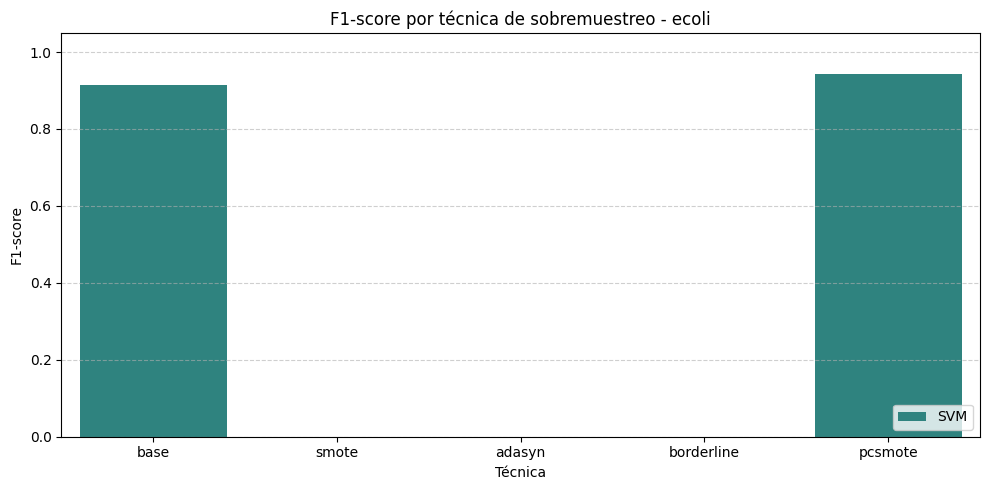

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el resumen
df = pd.read_csv("../resultados/resumen_mejores_por_tecnica.csv")

# Ajustar orden de técnicas para mejor visualización
orden_tecnicas = ['base', 'smote', 'adasyn', 'borderline', 'pcsmote']
df['tecnica'] = pd.Categorical(df['tecnica'], categories=orden_tecnicas, ordered=True)

# Plot por dataset
for dataset in df['dataset'].unique():
    plt.figure(figsize=(10, 5))
    df_sub = df[df['dataset'] == dataset].sort_values("tecnica")

    sns.barplot(
        data=df_sub,
        x="tecnica",
        y="f1_score",
        hue="modelo",  # opcional: para ver qué modelo dio ese resultado
        dodge=False,
        palette="viridis"
    )

    plt.title(f"F1-score por técnica de sobremuestreo - {dataset}")
    plt.ylabel("F1-score")
    plt.ylim(0, 1.05)
    plt.xlabel("Técnica")
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.legend(loc="lower right")
    plt.show()
